#                                                                # -----------------------------librerías extra

In [218]:
using ProgressMeter
using Cubature
using PyPlot

In [219]:
using Graf
using nintegrate

In [220]:
function integrar_matriz_trapecios(A,xmin,xmax,ymin,ymax,iteracionesx,iteracionesy)
    dx = (xmax-xmin)/(iteracionesx-1)
    dy = (ymax-ymin)/(iteracionesy-1)

    sum=0;
    #! calculate the corner's terms
    sum = A[1,1]+A[1,end]+A[end,1]+A[end,end]


    #! calculate single sums
    for i in 2:iteracionesx-1
        sum = sum + 2.0*(A[i,1]+A[i,end])
    end

    for i in 2:iteracionesy-1
        sum = sum + 2.0*(A[1,i]+A[end,i])
    end 

    #! calculate the double sum
    for i in 2:iteracionesx-1
        for j in 2:iteracionesy-1
                sum = sum + 4*A[i,j]
        end
    end

    integral = dx*dy*(sum)/4
    return integral
end









function norma_cuadrada(A)
    real(conj(A).*(A))
end



function norma_matriz(A,iteracionesr,iteracionesz,rmax,zmax)
    dr=rmax/iteracionesr
    dz=2*zmax/iteracionesz
    Integral=0.0;
    
    for i in 1:iteracionesr+1 
        for  j in 1:iteracionesz+1
            Integral=Integral+norma_cuadrada(A[i,j])*dr*dz;
        end
    end
    
    return sqrt(Integral)
    
end

norma_matriz (generic function with 1 method)

rmax=1.0;
rmin=0.0;
zmax=1.0;
zmin=0.0;
iteracionesz=1000;
iteracionesr=iteracionesz;
f(r,z)=r^2+z^2;
A=gencodominio2D([zmin,zmax],[0.0,rmax],iteracionesz,f);
integrar_matriz_trapecios(A,rmin,rmax,zmin,zmax,iteracionesr,iteracionesz)

### ----------------------------

In [221]:
divisor_alfa=100;
DT=1;

In [96]:
const hbarr=6.62606957e-34;
const Kb=1.3806488e-23
m=144.42e-27/2;

lambda=1.0

omegaz =150.0
omegar =lambda*omegaz;

alfa=5.8e-9;
alfa=alfa/divisor_alfa;
g_alfa=4.0*π*hbarr^2*alfa/m;

omegam=(omegar^2*omegaz)^(1/3);
Npart=10.0^5.0;
mu=0.5*(15^(2/5))*hbarr*omegam*(Npart*alfa*sqrt(m*omegam/hbarr))^(2.0/5.0); #(hbarr/2) *(2*omegar+omegaz);#


n=mu/g_alfa
c = sqrt(n*g_alfa/m);


#------------Parámetros característicos del solitón bosónico
ksi=1/sqrt(4*pi*n*alfa);
beta=0.0;
algo=11.0
z0=algo*ksi;
gama=1/(sqrt(1-beta^2));


In [222]:
m/(4*pi*hbarr*alfa*n)==ksi/c

true

### ----Función de onda

In [98]:

function U(r::Float64,z::Float64)
    (1/2)*m*((omegar*r)^2 + (omegaz*z)^2)
end

function n_tf(r::Float64,z::Float64)            
    if  mu-U(r,z)>0 0
        return (mu-U(r,z))/(g_alfa)              
    end
    return 0       
end


function sol(z::Float64)
1#(tanh((z-z0)/(ksi*gama)))/gama
end

function FUNCIONTF0(r::Float64,z::Float64)
    sqrt(n_tf(r,z))#*(sol(z)+im*beta)
end

function FUNCIONTF0(v::Vector{Float64})
    FUNCIONTF0(v[1],v[2])
end


FUNCIONTF0 (generic function with 2 methods)

In [99]:
rmax_estatico=sqrt(2*mu/(m*omegar^2))
zmax_estatico=sqrt(2*mu/(m*omegaz^2))


function rmaxintegrar(t::Float64)
    rmax_estatico/sqrt(abs(sin(omegar*t)))
end

function zmaxintegrar(t::Float64)
    zmax_estatico/sqrt(abs(sin(omegaz*t)))
end



rmaxevaluar=2.5*rmax_estatico;
zmaxevaluar=2.5*zmax_estatico;



# El tiempo

In [100]:
#unidades 0A
EOA=hbarr*omegam;
tOA=1/omegam;
lOA=sqrt(hbarr/(m*omegam));


t1=ksi/c;

t0=tOA;

In [101]:
t1/t0

0.7630197371974001

# La propagación de la función de onda en el esquema de interacción sólo por el presión cuántica

 Resolver $i\hbar \frac{d \psi_I(t)}{d T} = g \rho_I(t)  \psi_I(t)$
 
 $\psi_I(t+dt) = \psi_I(t)- \frac{ig}{\hbar} \rho_I(t)  \psi_I(t)$

In [239]:
iteracionest=1000
resolucion=100;

delta_t=t0/iteracionest;
uno=eye(Complex128,resolucion+1,resolucion+1);

funcion_de_onda=zeros(Complex128,resolucion+1,resolucion+1,iteracionest+1);
constante_normalizacion=zeros(Float64,iteracionest+1);

funcion_de_onda[:,:,1]=gencodominio2D([-zmax_estatico,zmax_estatico],[0.0,rmax_estatico],resolucion+1,FUNCIONTF0);
constante_normalizacion[1]=integrar_matriz_trapecios(norma_cuadrada(funcion_de_onda[:,:,1]),0.0,rmax_estatico,-zmax_estatico,zmax_estatico,iteracionesr,iteracionesz)
funcion_de_onda[:,:,1]=funcion_de_onda[:,:,1]/sqrt(constante_normalizacion[1])

for i in 2:iteracionest
    funcion_de_onda[:,:,i]=funcion_de_onda[:,:,i-1]-(g_alfa/hbarr*delta_t)*im*(norma_cuadrada(funcion_de_onda[:,:,i-1])).*funcion_de_onda[:,:,i-1] 
    constante_normalizacion[i]=integrar_matriz_trapecios(norma_cuadrada(funcion_de_onda[:,:,i]),0.0,rmax_estatico,-zmax_estatico,zmax_estatico,iteracionesr,iteracionesz)
    funcion_de_onda[:,:,i]=funcion_de_onda[:,:,i]/sqrt(constante_normalizacion[i])
end

In [240]:
t0/t1

1.310582087526382

In [230]:
(g_alfa/hbarr*delta_t)*n/4

0.00032764552188159545

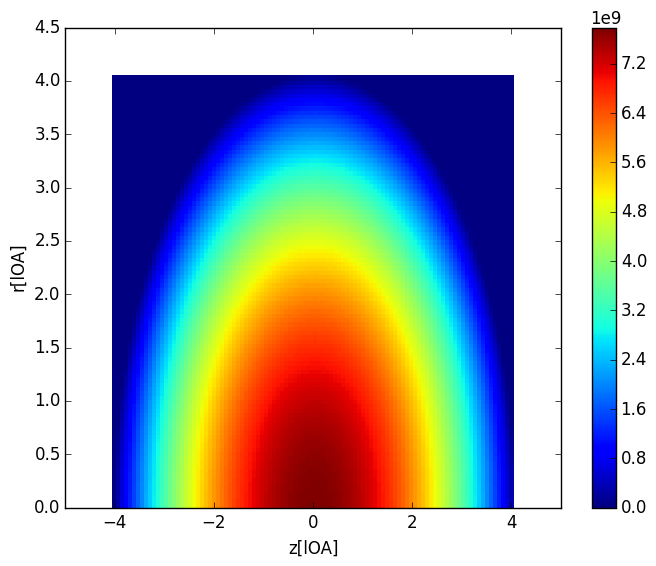

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe80a9c6320>

In [234]:
i=1
grafdensidad([-zmaxevaluar/lOA,zmaxevaluar/lOA],[0.0,rmaxevaluar/lOA],101,norma_cuadrada(funcion_de_onda[:,:,i]),"","z[lOA]","r[lOA]","barra")

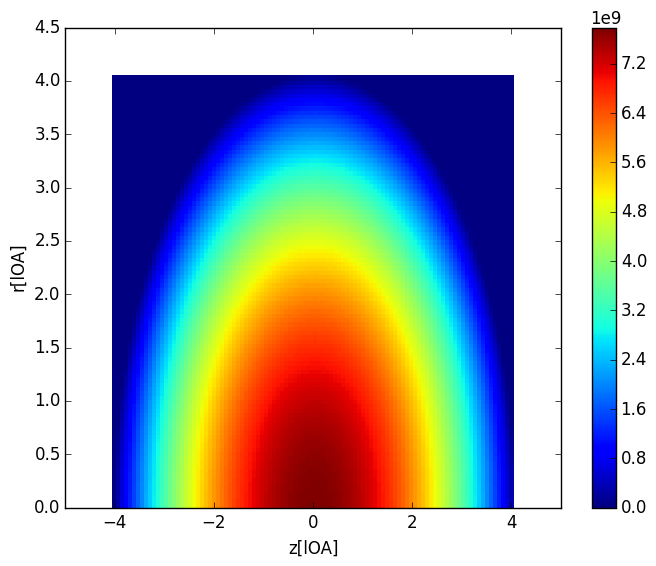

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe80a77fa70>

In [236]:
i=iteracionest
grafdensidad([-zmaxevaluar/lOA,zmaxevaluar/lOA],[0.0,rmaxevaluar/lOA],101,norma_cuadrada(funcion_de_onda[:,:,i]),"","z[lOA]","r[lOA]","barra")

In [186]:
n

2.9394019838873055e19

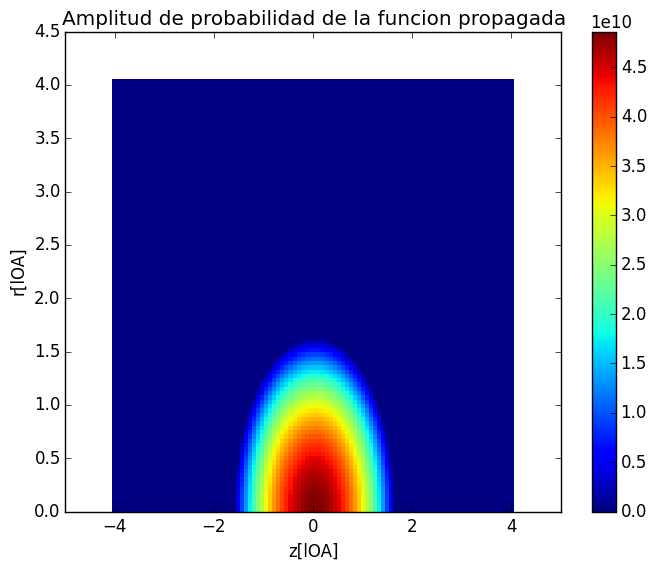

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe80b172b48>

In [185]:
i=1
grafdensidad([-zmaxevaluar/lOA,zmaxevaluar/lOA],[0.0,rmaxevaluar/lOA],101,norma_cuadrada(funcion_de_onda[:,:,i]),"Amplitud de probabilidad de la funcion propagada","z[lOA]","r[lOA]","barra")

In [45]:
integrar_matriz_trapecios(norma_cuadrada(funcion_de_onda[:,:,1]/constante_normalizacion[1]),0.0,rmaxevaluar,-zmaxevaluar,zmaxevaluar,iteracionesr,iteracionesz)

1.0

In [34]:
# ----------------------------------------------------------------------------------------------

In [50]:
rmax_estatico/lOA

1.6190009805595431

tiempos=linspace(tOA/100,tOA,101);
rmax=zeros(101);
zmax=zeros(101);

[rmax[i]=1/sqrt(abs(sin(omegar*tiempos[i]))) for i in 1:101]; 
[zmax[i]=1/sqrt(abs(sin(omegaz*tiempos[i]))) for i in 1:101]; 

PyPlot.plot(rmax)

PyPlot.plot(zmax)

# Inspeccionar la función a integrar

In [41]:
#########EN UNIDADES dependientes del tiempo

N_est=(m/hbarr)^(3/2)*omegar*sqrt(omegaz)/sqrt(2*π);


function sol(z::Float64,t)
    tanh((z*sqrt(abs(sin(omegaz*t)))-z0)/(ksi*gama))/gama
end

function fase_rr1(r1::Float64,r::Float64,t::Float64)
    (m*omegar/(2*hbarr))*((r1^2+r^2)*cos(omegar*t))+π/4
end

function fase_zz1(z1::Float64,z::Float64,t::Float64)
    (m*omegaz/(2*hbarr))*((z1^2+z^2)*cos(omegaz*t)-2*z*z1)
end


function Bessel0(r1::Float64,r::Float64)
    besselj0(abs(m*omegar*r*r1/hbarr))
end

function U(r::Float64,z::Float64,t::Float64)
    0.5*(m)*((omegar*r)^2*sin(omegar*t) + (omegaz*z)^2*sin(omegaz*t))
end



function n_tf(r::Float64,z::Float64,t::Float64)            
    if  mu-U(r,z,t)>0 0
        return (mu-U(r,z,t))/(n*g_alfa)              
    end
    return 0       
end


function Rre(r1::Float64,r::Float64,t::Float64)
    Bessel0(r1,r)*r1*cos(fase_rr1(r1,r,t))
end


function Rim(r1::Float64,r::Float64,t::Float64)
    Bessel0(r1,r)*r1*sin(fase_rr1(r1,r,t))
end


function Zre(z1::Float64,z::Float64,t::Float64)
    cos(fase_zz1(z1,z,t))*sol(z1,t)-beta*sin(fase_zz1(z1,z,t))
end

function Zim(z1::Float64,z::Float64,t::Float64)
    sin(fase_zz1(z1,z,t))*sol(z1,t)+beta*cos(fase_zz1(z1,z,t))
end


function R_funcion_a_integrar(r1::Float64,z1::Float64,r::Float64,z::Float64,t::Float64)
    Rre(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zre(z1,z,t)-Rim(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zim(z1,z,t)
end


function I_funcion_a_integrar(r1::Float64,z1::Float64,r::Float64,z::Float64,t::Float64)
    Rre(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zim(z1,z,t)+Rim(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zre(z1,z,t)
end


R_funcion_a_integrar(v::Vector{Float64},r,z,t)=R_funcion_a_integrar(v[1],v[2],r,z,t)

I_funcion_a_integrar(v::Vector{Float64},r,z,t)=I_funcion_a_integrar(v[1],v[2],r,z,t)


I_funcion_a_integrar (generic function with 2 methods)

In [42]:
#########EN UNIDADES dependientes del tiempo

N_est=(m/hbarr)^(3/2)*omegar*sqrt(omegaz)/sqrt(2*π);


function sol(z::Float64,t)
    1
    #tanh((z*sqrt(abs(sin(omegaz*t)))-z0)/(ksi*gama))/gama
end

function fase_rr1(r1::Float64,r::Float64,t::Float64)
    (m*omegar/(2*hbarr))*((r1^2+r^2)*cos(omegar*t))+π/4
end

function fase_zz1(z1::Float64,z::Float64,t::Float64)
    (m*omegaz/(2*hbarr))*((z1^2+z^2)*cos(omegaz*t)-2*z*z1)
end


function Bessel0(r1::Float64,r::Float64)
    besselj0(abs(m*omegar*r*r1/hbarr))
end

function U(r::Float64,z::Float64,t::Float64)
    0.5*(m)*((omegar*r)^2*sin(omegar*t) + (omegaz*z)^2*sin(omegaz*t))
end



function n_tf(r::Float64,z::Float64,t::Float64)            
    if  mu-U(r,z,t)>0 0
        return (mu-U(r,z,t))/(n*g_alfa)              
    end
    return 0       
    
    
#    ((m/(π*hbarr))^(3/2)*omegar*omegaz^(1/2)*exp(  -(m*omegar/(hbarr))*r^2*sin(omegar*t)-(m*omegaz/(hbarr))*z^2*sin(omegaz*t))  )    

    
end


function Rre(r1::Float64,r::Float64,t::Float64)
    Bessel0(r1,r)*r1*cos(fase_rr1(r1,r,t))
end


function Rim(r1::Float64,r::Float64,t::Float64)
    Bessel0(r1,r)*r1*sin(fase_rr1(r1,r,t))
end


function Zre(z1::Float64,z::Float64,t::Float64)
    cos(fase_zz1(z1,z,t))*sol(z1,t)-beta*sin(fase_zz1(z1,z,t))
end

function Zim(z1::Float64,z::Float64,t::Float64)
    sin(fase_zz1(z1,z,t))*sol(z1,t)+beta*cos(fase_zz1(z1,z,t))
end


function R_funcion_a_integrar(r1::Float64,z1::Float64,r::Float64,z::Float64,t::Float64)
    Rre(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zre(z1,z,t)-Rim(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zim(z1,z,t)
end


function I_funcion_a_integrar(r1::Float64,z1::Float64,r::Float64,z::Float64,t::Float64)
    Rre(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zim(z1,z,t)+Rim(r1,r,t)*sqrt(n_tf(r1,z1,t))*Zre(z1,z,t)
end


R_funcion_a_integrar(v::Vector{Float64},r,z,t)=R_funcion_a_integrar(v[1],v[2],r,z,t)

I_funcion_a_integrar(v::Vector{Float64},r,z,t)=I_funcion_a_integrar(v[1],v[2],r,z,t)


I_funcion_a_integrar (generic function with 2 methods)

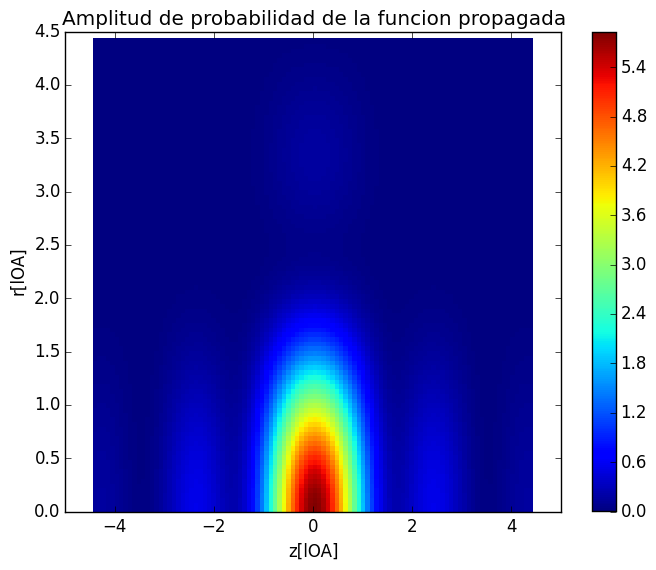

In [35]:
divisor_alfa=10;
A=readdlm("salida a 5*1  alfa entre 10  resol de 100*100 .dat", );
grafdensidad([-zmaxintegrar(t0)/lOA,zmaxintegrar(t0)/lOA],[0.0,rmaxintegrar(t0)/lOA],101,A,"Amplitud de probabilidad de la funcion propagada","z[lOA]","r[lOA]","barra")
savefig("Perfil a tiempo 5 con alfa entre $divisor_alfa lambda=$lambda .png")

In [19]:
divisor_alfa

10